# Fake News Detection Project Overview

This project showcases a machine learning pipeline designed to classify news articles as either true or fake. The project leverages Natural Language Processing (NLP) for text preprocessing and sentiment analysis, followed by various machine learning algorithms, including Support Vector Machine (SVM), Logistic Regression, and a Long Short-Term Memory (LSTM) neural network for classification. The code demonstrates data preprocessing, model training, evaluation, and the generation of insightful visualizations.

## The code of the project

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud,STOPWORDS

In [4]:
df_fake=pd.read_csv (r'/kaggle/input/fake-news-text-dataset/DataSet_Misinfo_FAKE.csv')
df_fake['truthfulness']=0
df_fake=df_fake.drop(columns=['Unnamed: 0'], axis=1)
df_fake.to_csv('df_fake.csv', index=False)

In [5]:
df_fake=pd.read_csv (r'/kaggle/working/df_fake.csv')
df_fake

text  truthfulness
0      Donald Trump just couldn t wish all Americans ...             0
1      House Intelligence Committee Chairman Devin Nu...             0
2      On Friday, it was revealed that former Milwauk...             0
3      On Christmas day, Donald Trump announced that ...             0
4      Pope Francis used his annual Christmas Day mes...             0
...                                                  ...           ...
43637  The USA wants to divide Syria.\r\n\r\nGreat Br...             0
43638  The Ukrainian coup d'etat cost the US nothing ...             0
43639  The European Parliament falsifies history by d...             0
43640  The European Parliament falsifies history by d...             0
43641  A leading FSB officer, Segey Beseda, said duri...             0

[43642 rows x 2 columns]

In [6]:
df_true=pd.read_csv (r'/kaggle/input/fake-news-text-dataset/DataSet_Misinfo_TRUE.csv')
df_true['truthfulness']=1
df_true=df_true.drop(columns=['Unnamed: 0'], axis=1)
df_true.to_csv('df_true.csv', index=False)

In [7]:
df_true=pd.read_csv (r'/kaggle/working/df_true.csv')
df_true

text  truthfulness
0      The head of a conservative Republican faction ...             1
1      Transgender people will be allowed for the fir...             1
2      The special counsel investigation of links bet...             1
3      Trump campaign adviser George Papadopoulos tol...             1
4      President Donald Trump called on the U.S. Post...             1
...                                                  ...           ...
34970  Most conservatives who oppose marriage equalit...             1
34971  The freshman senator from Georgia quoted scrip...             1
34972  The State Department told the Republican Natio...             1
34973  ADDIS ABABA, Ethiopia —President Obama convene...             1
34974  Jeb Bush Is Suddenly Attacking Trump. Here's W...             1

[34975 rows x 2 columns]

In [37]:
df= pd.concat([df_true,df_fake])
print(df)

                                                    text  truthfulness
0      The head of a conservative Republican faction ...             1
1      Transgender people will be allowed for the fir...             1
2      The special counsel investigation of links bet...             1
3      Trump campaign adviser George Papadopoulos tol...             1
4      President Donald Trump called on the U.S. Post...             1
...                                                  ...           ...
43637  The USA wants to divide Syria.\r\n\r\nGreat Br...             0
43638  The Ukrainian coup d'etat cost the US nothing ...             0
43639  The European Parliament falsifies history by d...             0
43640  The European Parliament falsifies history by d...             0
43641  A leading FSB officer, Segey Beseda, said duri...             0

[78617 rows x 2 columns]


In [38]:
# # setting the path for joining multiple files
# files = os.path.join("/kaggle/working/", "df_*.csv")
# # list of merged files returned
# files = glob.glob(files)
# files

In [39]:
# print("Resultant CSV after joining all CSV files at a particular location...")
# # joining files with concat and read_csv
# df = pd.concat(map(pd.read_csv, files), ignore_index=True)
# print(df)

In [10]:
len(df['text'].unique())
df['text'].duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)

In [11]:
#to make suffle
from sklearn.utils import shuffle
df = shuffle(df)

In [12]:
df.shape

(68605, 2)

In [13]:
df.head()

text  truthfulness
77223  Illuminates plan to use Islam to start the thi...             0
51813  The EPA had already started expanding powers o...             0
32270  New Jersey Gov. Chris Christie is refusing to ...             1
18966  U.S. President Donald Trump and Spain s Prime ...             1
44274  This is an interesting development in the Muel...             0

In [14]:
df.tail()

text  truthfulness
65947  November 2015 Ads Russia reveals chilling firs...             0
23387  When the two men plunged into the unforgiving ...             1
5008   The American Civil Liberties Union is launchin...             1
44385  Here s more proof that liberals don t like fre...             0
67313  Pieczenik: ‘There is a coup in the White House...             0

In [15]:
#checking columns in our data
df.columns

Index(['text', 'truthfulness'], dtype='object')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68605 entries, 77223 to 67313
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          68604 non-null  object
 1   truthfulness  68605 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [17]:
# Check the nulls
df.isna().sum(axis=0)

text            1
truthfulness    0
dtype: int64

In [18]:
df = df.dropna()
print(df)

                                                    text  truthfulness
77223  Illuminates plan to use Islam to start the thi...             0
51813  The EPA had already started expanding powers o...             0
32270  New Jersey Gov. Chris Christie is refusing to ...             1
18966  U.S. President Donald Trump and Spain s Prime ...             1
44274  This is an interesting development in the Muel...             0
...                                                  ...           ...
65947  November 2015 Ads Russia reveals chilling firs...             0
23387  When the two men plunged into the unforgiving ...             1
5008   The American Civil Liberties Union is launchin...             1
44385  Here s more proof that liberals don t like fre...             0
67313  Pieczenik: ‘There is a coup in the White House...             0

[68604 rows x 2 columns]


# Exploratory Data Analysis (EDA)

truthfulness_values --- 
 1    34526
0    34078
Name: truthfulness, dtype: int64
********************************************************************************


Text(0, 0.5, 'Sentiment Count')

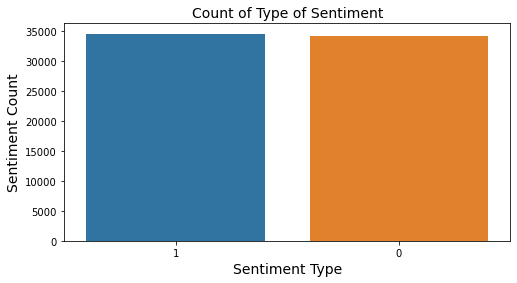

In [19]:
truthfulness_values = df['truthfulness'].value_counts() #index then values
print('truthfulness_values --- \n', truthfulness_values)
print('**'*40)

## Plotting
plt.figure(figsize=(8,4))
sns.countplot(x='truthfulness', data=df,
              order=truthfulness_values.index)
plt.title('Count of Type of Sentiment', fontsize=14, c='k')
plt.xlabel('Sentiment Type', fontsize=14, c='k')
plt.ylabel('Sentiment Count', fontsize=14, c='k')

# Wordcloud for positive reasons

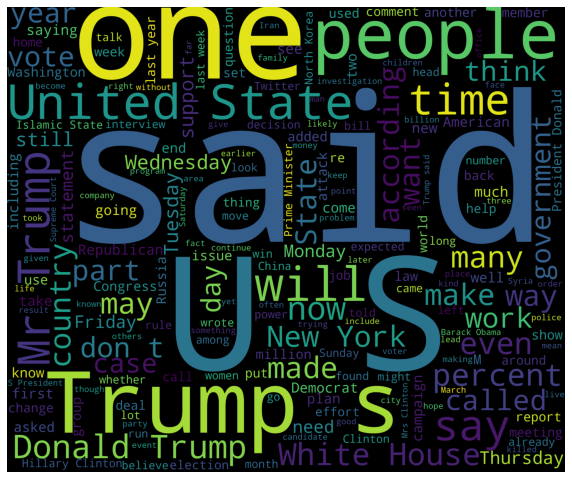

In [20]:
new_df=df[df['truthfulness']==1]
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Wordcloud for Negative sentiments of tweets

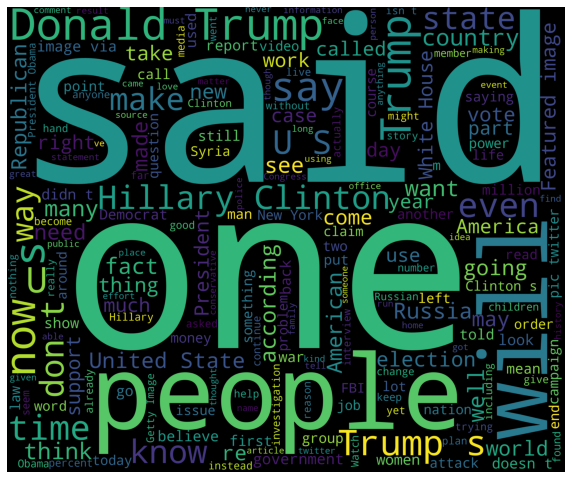

In [21]:
new_df=df[df['truthfulness']==0]
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Preprocessing the tweet text data

In [19]:
df['text']

77223    Illuminates plan to use Islam to start the thi...
51813    The EPA had already started expanding powers o...
32270    New Jersey Gov. Chris Christie is refusing to ...
18966    U.S. President Donald Trump and Spain s Prime ...
44274    This is an interesting development in the Muel...
                               ...                        
65947    November 2015 Ads Russia reveals chilling firs...
23387    When the two men plunged into the unforgiving ...
5008     The American Civil Liberties Union is launchin...
44385    Here s more proof that liberals don t like fre...
67313    Pieczenik: ‘There is a coup in the White House...
Name: text, Length: 68604, dtype: object

In [20]:
def tweet_to_words(tweet):
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

In [21]:
df['clean_tweet']=df['text'].apply(lambda x: tweet_to_words(x))
df['clean_tweet']

77223    illuminates plan use islam start third world w...
51813    epa already started expanding powers private p...
32270    new jersey gov chris christie refusing hand cr...
18966    u president donald trump spain prime minister ...
44274    interesting development mueller investigation ...
                               ...                        
65947    november ads russia reveals chilling first ima...
23387    two men plunged unforgiving wilderness adirond...
5008     american civil liberties union launching bills...
44385    proof liberals like free speech unless speech ...
67313    pieczenik coup white house going stop full sca...
Name: clean_tweet, Length: 68604, dtype: object

In [22]:
pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 6.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
#Removing Contractions
import contractions
for row in df['clean_tweet']:
    contractions.fix(row)

In [24]:
df.shape

(68604, 3)

In [25]:
df

text  truthfulness  \
77223  Illuminates plan to use Islam to start the thi...             0   
51813  The EPA had already started expanding powers o...             0   
32270  New Jersey Gov. Chris Christie is refusing to ...             1   
18966  U.S. President Donald Trump and Spain s Prime ...             1   
44274  This is an interesting development in the Muel...             0   
...                                                  ...           ...   
65947  November 2015 Ads Russia reveals chilling firs...             0   
23387  When the two men plunged into the unforgiving ...             1   
5008   The American Civil Liberties Union is launchin...             1   
44385  Here s more proof that liberals don t like fre...             0   
67313  Pieczenik: ‘There is a coup in the White House...             0   

                                             clean_tweet  
77223  illuminates plan use islam start third world w...  
51813  epa already started expanding powers private p...  
32270  new jersey gov chris christie refusing hand cr...  
18966  u president donald trump spain prime minister ...  
44274  interesting development mueller investigation ...  
...                                                  ...  
65947  november ads russia reveals chilling first ima...  
23387  two men plunged unforgiving wilderness adirond...  
5008   american civil liberties union launching bills...  
44385  proof liberals like free speech unless speech ...  
67313  pieczenik coup white house going stop full sca...  

[68604 rows x 3 columns]

In [26]:
df=df.head(14640)

# preparing the data for LSTM

In [29]:
#number of row
lenght_text =len(df['clean_tweet'])
max_words = len(set(" ".join(df['clean_tweet']).split()))
lenght_text,max_words

(14640, 95099)

In [30]:
#by turning each text into either a sequence of integers 
#(each integer being the index of a token in a dictionary) 
#dictionary make by words which is the most frequency is put first and take 0 ...
max_fatures =max_words # max_words
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['clean_tweet'].values)
X = tokenizer.texts_to_sequences(df['clean_tweet'].values)
X = pad_sequences(X)
X

array([[    0,     0,     0, ..., 16538,   832,   585],
       [    0,     0,     0, ...,   293,   193,  2948],
       [    0,     0,     0, ...,  2777,   406,   524],
       ...,
       [    0,     0,     0, ...,  3674,   111,    16],
       [    0,     0,     0, ...,  8235,   832,   585],
       [    0,     0,     0, ...,    73,  1190,   675]], dtype=int32)

In [31]:
X.shape

(14640, 8981)

In [32]:
Y = pd.get_dummies(df['truthfulness']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11712, 8981) (11712, 2)
(2928, 8981) (2928, 2)


# LSTM

In [33]:
embed_dim = 100
lstm_out = 100

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

2023-01-29 15:33:03.621799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:33:03.622826: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:33:03.724270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:33:03.725078: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:33:03.725857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8981, 100)         9509900   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 9,590,502
Trainable params: 9,590,502
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
batch_size = 32
history=model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size
          ,validation_data=(X_test, Y_test),callbacks=[early_stop])

2023-01-29 15:33:07.913228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-29 15:33:11.400983: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


366/366 [==============================] - 130s 340ms/step - loss: 0.2721 - accuracy: 0.8803 - val_loss: 0.2292 - val_accuracy: 0.9228
Epoch 2/20
366/366 [==============================] - 125s 342ms/step - loss: 0.0863 - accuracy: 0.9726 - val_loss: 0.2427 - val_accuracy: 0.9221
Epoch 3/20
366/366 [==============================] - 125s 342ms/step - loss: 0.0383 - accuracy: 0.9893 - val_loss: 0.2480 - val_accuracy: 0.9173


# word2vec

In [30]:
from gensim.models import Word2Vec
import pandas as pd
df_new=pd.DataFrame(x)
df_new['label']=y
df_new

clean_tweet  label
37396  issuing passports people donbas russia humanit...      0
11043  trump administration proposed billion wall spe...      0
20934  every day barack obama rubs radical transforma...      0
15482  irony lost us hillary compared president wante...      0
26806  world socialist web site telecommunications ca...      0
...                                                  ...    ...
50021  president elect donald trump transition team a...      1
8441   january u state department announced agency id...      0
33426  cnn also known clinton news network gone way t...      0
24006  shares two party corporate duopoly remains mir...      0
36562  start analyse positions within seven fact posi...      0

[14640 rows x 2 columns]

In [31]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

def tokenize(d):
    return word_tokenize(d)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
df_new['clean_tweet2']= df_new.clean_tweet.apply(clean_text).apply(tokenize)
df_new.clean_tweet2.head()

37396    [issuing, passports, people, donbas, russia, h...
11043    [trump, administration, proposed, billion, wal...
20934    [every, day, barack, obama, rubs, radical, tra...
15482    [irony, lost, us, hillary, compared, president...
26806    [world, socialist, web, site, telecommunicatio...
Name: clean_tweet2, dtype: object

In [33]:
from gensim.models import Word2Vec

texts_w2v = df_new.clean_tweet2.to_list()

w2v = Word2Vec(sentences = texts_w2v, window = 3,
               vector_size = 100, min_count = 5, workers = 4, sg = 1) #skip gram(1)

In [34]:
def get_avg_vector(sent):
    vector = np.zeros(100)
    total_words = 0
    for word in sent.split():        
        if word in w2v.wv.index_to_key:
            vector += w2v.wv.word_vec(word)
            total_words += 1
    if total_words > 0:
        return vector / total_words
    else:
        return vector

In [35]:
df_new['w2v_vector'] = df_new['clean_tweet'].map(get_avg_vector)
df_new[['clean_tweet', 'w2v_vector']].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  


clean_tweet  \
37396  issuing passports people donbas russia humanit...   
11043  trump administration proposed billion wall spe...   
20934  every day barack obama rubs radical transforma...   
15482  irony lost us hillary compared president wante...   
26806  world socialist web site telecommunications ca...   

                                              w2v_vector  
37396  [-0.13396773871500045, 0.0682527300377842, 0.0...  
11043  [-0.12361937871233361, 0.24924425296027397, 0....  
20934  [-0.08984974873114314, 0.07511963917113852, 0....  
15482  [0.004703065353691921, 0.1888954165356833, 0.1...  
26806  [-0.12447782966685055, 0.178642642948976, 0.13...

In [36]:
df_new

clean_tweet  label  \
37396  issuing passports people donbas russia humanit...      0   
11043  trump administration proposed billion wall spe...      0   
20934  every day barack obama rubs radical transforma...      0   
15482  irony lost us hillary compared president wante...      0   
26806  world socialist web site telecommunications ca...      0   
...                                                  ...    ...   
50021  president elect donald trump transition team a...      1   
8441   january u state department announced agency id...      0   
33426  cnn also known clinton news network gone way t...      0   
24006  shares two party corporate duopoly remains mir...      0   
36562  start analyse positions within seven fact posi...      0   

                                            clean_tweet2  \
37396  [issuing, passports, people, donbas, russia, h...   
11043  [trump, administration, proposed, billion, wal...   
20934  [every, day, barack, obama, rubs, radical, tra...   
15482  [irony, lost, us, hillary, compared, president...   
26806  [world, socialist, web, site, telecommunicatio...   
...                                                  ...   
50021  [president, elect, donald, trump, transition, ...   
8441   [january, u, state, department, announced, age...   
33426  [cnn, also, known, clinton, news, network, gon...   
24006  [shares, two, party, corporate, duopoly, remai...   
36562  [start, analyse, positions, within, seven, fac...   

                                              w2v_vector  
37396  [-0.13396773871500045, 0.0682527300377842, 0.0...  
11043  [-0.12361937871233361, 0.24924425296027397, 0....  
20934  [-0.08984974873114314, 0.07511963917113852, 0....  
15482  [0.004703065353691921, 0.1888954165356833, 0.1...  
26806  [-0.12447782966685055, 0.178642642948976, 0.13...  
...                                                  ...  
50021  [-0.09822906524652485, 0.16518746110508165, 0....  
8441   [0.031699268598733295, 0.12256869836380917, 0....  
33426  [-0.03651866976349171, 0.16900703827447996, 0....  
24006  [-0.05250439144014281, 0.1765158593872456, 0.1...  
36562  [-0.2518750793921451, 0.058449284600404404, 0....  

[14640 rows x 4 columns]

In [37]:
df_new['index_column'] = df_new.index

#using reset_index() to set index into column
#df2=df_new.reset_index()

#Using reset_index, inplace=True
df_new.reset_index(inplace=True)

In [38]:
df_new

index                                        clean_tweet  label  \
0      37396  issuing passports people donbas russia humanit...      0   
1      11043  trump administration proposed billion wall spe...      0   
2      20934  every day barack obama rubs radical transforma...      0   
3      15482  irony lost us hillary compared president wante...      0   
4      26806  world socialist web site telecommunications ca...      0   
...      ...                                                ...    ...   
14635  50021  president elect donald trump transition team a...      1   
14636   8441  january u state department announced agency id...      0   
14637  33426  cnn also known clinton news network gone way t...      0   
14638  24006  shares two party corporate duopoly remains mir...      0   
14639  36562  start analyse positions within seven fact posi...      0   

                                            clean_tweet2  \
0      [issuing, passports, people, donbas, russia, h...   
1      [trump, administration, proposed, billion, wal...   
2      [every, day, barack, obama, rubs, radical, tra...   
3      [irony, lost, us, hillary, compared, president...   
4      [world, socialist, web, site, telecommunicatio...   
...                                                  ...   
14635  [president, elect, donald, trump, transition, ...   
14636  [january, u, state, department, announced, age...   
14637  [cnn, also, known, clinton, news, network, gon...   
14638  [shares, two, party, corporate, duopoly, remai...   
14639  [start, analyse, positions, within, seven, fac...   

                                              w2v_vector  index_column  
0      [-0.13396773871500045, 0.0682527300377842, 0.0...         37396  
1      [-0.12361937871233361, 0.24924425296027397, 0....         11043  
2      [-0.08984974873114314, 0.07511963917113852, 0....         20934  
3      [0.004703065353691921, 0.1888954165356833, 0.1...         15482  
4      [-0.12447782966685055, 0.178642642948976, 0.13...         26806  
...                                                  ...           ...  
14635  [-0.09822906524652485, 0.16518746110508165, 0....         50021  
14636  [0.031699268598733295, 0.12256869836380917, 0....          8441  
14637  [-0.03651866976349171, 0.16900703827447996, 0....         33426  
14638  [-0.05250439144014281, 0.1765158593872456, 0.1...         24006  
14639  [-0.2518750793921451, 0.058449284600404404, 0....         36562  

[14640 rows x 6 columns]

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [42]:
model_params = {'random_state':42}
model_list = [LogisticRegression(**model_params, solver='liblinear'),
              RandomForestClassifier(**model_params),
#               MultinomialNB(),  # Don't use Naive Bayes since w2v_vector contains negative numbers, then it causes an error.
              SVC(**model_params)]
model_name = ['LogisticRegression', 'RandomForest', 'SupportVectorMachine']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# 
for model, model_name in zip(model_list, model_name):
    for n_fold, (trn_idx, vld_idx) in enumerate(skf.split(df_new.index, df_new.label)):        
        X_trn = np.stack(df_new.loc[trn_idx, 'w2v_vector'])
        y_trn = df_new.loc[trn_idx, 'label']
        
        X_vld = np.stack(df_new.loc[vld_idx, 'w2v_vector'])
        y_vld = df_new.loc[vld_idx, 'label']        
        
        model.fit(X_trn, y_trn)
        pred_col = f"{model_name}_w2v_pred"
        df_new.loc[vld_idx, pred_col] = model.predict(X_vld)
        

    print(f"Model: {model_name}, Word2Vec, Accuracy: {accuracy_score(df_new.label, df_new[pred_col]):.3%}\n")

Model: LogisticRegression, Word2Vec, Accuracy: 87.917%

Model: RandomForest, Word2Vec, Accuracy: 87.596%

Model: SupportVectorMachine, Word2Vec, Accuracy: 89.372%



# preparing data to use SVM

In [27]:
x = df.clean_tweet
y = df.truthfulness

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=.20, random_state=42)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

11712 11712
2928 2928


In [29]:
#vector words or word embadding
#Using CountVectorizer to Extracting Features from Text
from sklearn.feature_extraction.text import CountVectorizer
# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [30]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [31]:
x_train_dtm.shape

(11712, 84045)

In [32]:
#training SVM model with linear kernel
#Support Vector Classification-wrapper around SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state = 10)
model.fit(x_train_dtm, y_train)

SVC(kernel='linear', random_state=10)

In [33]:
#predicting output for test data
pred = model.predict(x_test_dtm)
#accuracy score
accuracy_score(y_test,pred)

0.9012978142076503

In [34]:
cm = confusion_matrix(y_test, pred)
cm

array([[1321,  156],
       [ 133, 1318]])

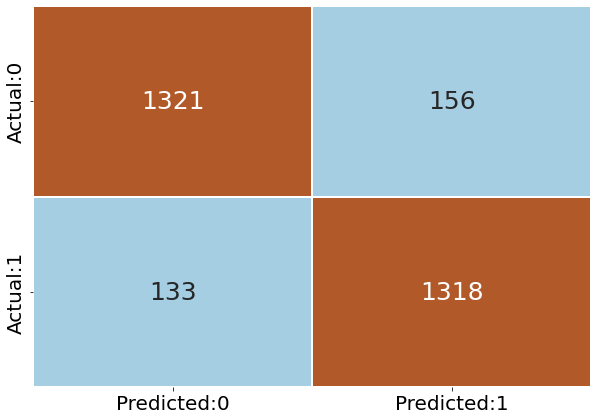

In [35]:
#defining the size of the canvas
plt.rcParams['figure.figsize'] = [10,7]
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
#plotting the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

In [36]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1477
           1       0.89      0.91      0.90      1451

    accuracy                           0.90      2928
   macro avg       0.90      0.90      0.90      2928
weighted avg       0.90      0.90      0.90      2928



# logisticRegression and TfidfVectorizer and using all df

In [41]:
len(df)


68604

In [42]:
df

text  truthfulness  \
50705  U.S. President-elect Donald Trump plans meetin...             1   
8494   In a recent candid interview with the Washingt...             0   
72577  Lancashire Police has introduced a “Police wit...             1   
6944   The 2016 crop of GOP Clown Car candidates is s...             0   
39909  For Western Europe, the territory to the East ...             0   
...                                                  ...           ...   
47109  The mayor of Paris, where a landmark global cl...             1   
5325   A Detroit man has been sentenced to 25-50 year...             0   
9295   What a bitter woman! She blames a different th...             0   
24517  by DML DAILY / November 4, 2016 / IMMIGRATION ...             0   
64990  The parents and lawyers of a Philippine high s...             1   

                                             clean_tweet  
50705  u president elect donald trump plans meetings ...  
8494   recent candid interview washington post democr...  
72577  lancashire police introduced police pride vehi...  
6944   crop gop clown car candidates simply awful don...  
39909  western europe territory east annex resources ...  
...                                                  ...  
47109  mayor paris landmark global climate agreement ...  
5325   detroit man sentenced years prison year old so...  
9295   bitter woman blames different thing every week...  
24517  dml daily november immigration illegal aliens ...  
64990  parents lawyers philippine high school student...  

[68604 rows x 3 columns]

In [43]:
x = df["clean_tweet"]
y = df["truthfulness"]

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

In [46]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(xv_train,y_train)

LogisticRegression()

In [47]:
pred_lr=LR.predict(xv_test)

In [48]:
LR.score(xv_test, y_test)

0.9345227683516996

In [30]:
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8508
           1       0.94      0.94      0.94      8643

    accuracy                           0.94     17151
   macro avg       0.94      0.94      0.94     17151
weighted avg       0.94      0.94      0.94     17151




### Conclusion

This project presents a comprehensive machine learning pipeline for detecting fake news using various NLP techniques. Through model training and testing, we observed the effectiveness of different algorithms, with each providing unique insights into the text data. The project demonstrates valuable skills in data preprocessing, feature extraction, model implementation, and evaluation, making it a robust example of a complete NLP and classification workflow.